### Create confusion matrix

In [73]:
from os import listdir, makedirs
from os.path import isfile, join, exists
import pandas as pd
import numpy as np
from itertools import product
###############################################################################################
path = r'/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/Olfacto/'
path_df = join(path,'Bilan_classif/2_signif_elecs_patients_phase/')
path2save = join(path,'Bilan_classif/3_Figures_Phase/')
###############################################################################################

freqs = ['2_theta']#['0_VLFC','1_delta','2_theta','3_alpha']
option = '75' #'all'
conds = {'0':['bad','good'],'1':['poor','partial'],'2':['partial','detailed'],
     '3':['poor','detailed']}
option = 5 #npatients

#Create the list of rois to create the global matrix
roi75 = np.array([])
for cond in conds:
    for freq in freqs:
        if cond == '0':
            filename = path_df+cond+'_Classif_'+conds[cond][1]+'_'+conds[cond][0]+'_'+freq+'_win1_patients'+str(option)+'.csv'
        else:
            filename = path_df+cond+'_Classif_'+conds[cond][0]+'_'+conds[cond][1]+'_'+freq+'_win1_patients'+str(option)+'.csv'
        if isfile(filename):
            df75 = pd.read_csv(filename)
            roi75 = np.hstack((roi75,df75['s_aal_RL'].values)) if np.size(roi75) else df75['s_aal_RL'].values
    roi75 = np.delete(roi75,np.where(roi75=='Not f'),axis=0)
    roi_all = np.unique(roi75)
print(option,roi_all.shape)

5 (1,)


### Create the ROI matrix // nb of patients

In [74]:
#Create the matrix
big_matrix = np.array([])
x_freq, x_cond = [], []
groupby = 'cond'

for cond,freq in product(sorted(conds),freqs[:]): #trick to impose iteration order for conds & freqs
    print(freq, conds[cond][:2])
    x_freq.append(freq[2:].capitalize())
    x_cond.append(conds[cond][0][:2].capitalize()+'/'+conds[cond][1][:2].capitalize())
    if cond == '0':
        filename75 = path_df+cond+'_Classif_'+conds[cond][1]+'_'+conds[cond][0]+'_'+freq+'_win1_patients'+str(option)+'.csv'
    else:
        filename75 = path_df+cond+'_Classif_'+conds[cond][0]+'_'+conds[cond][1]+'_'+freq+'_win1_patients'+str(option)+'.csv'
    sig75, sig = None, np.array([])
    if isfile(filename75):
        sig75 = pd.read_csv(filename75)['s_aal_RL'].values
        for roi in roi_all:
            if roi in sig75:
                sig = np.hstack((sig,option)) if np.size(sig) else option
            if roi not in sig75:
                sig = np.hstack((sig,0)) if np.size(sig) else 0
    if sig75 is None:
        for roi in roi_all:
            sig = np.hstack((sig,0)) if np.size(sig) else 0
    big_matrix = np.vstack((big_matrix,sig)) if np.size(big_matrix) else sig
big_matrix = big_matrix.T
_, idx = np.unique(x_cond,return_index=True) #to keep order
x_cond = [x_cond[i] for i in sorted(idx)]
print('big mama',big_matrix.shape, x_freq, x_cond,big_matrix)

# Create mask of positions in x (with float datatype) where NaNs are to be put
big_matrix = big_matrix.astype(np.float32)
# big_matrix = big_matrix[big_matrix==0] = np.nan
for i, j in product(range(big_matrix.shape[0]), range(big_matrix.shape[1])):
    if big_matrix[i,j] == 0:
        big_matrix[i,j] = np.nan
print(big_matrix, x_freq, x_cond)
   

2_theta ['bad', 'good']
2_theta ['poor', 'partial']
2_theta ['partial', 'detailed']
2_theta ['poor', 'detailed']
big mama (1, 4) ['Theta', 'Theta', 'Theta', 'Theta'] ['Ba/Go', 'Po/Pa', 'Pa/De', 'Po/De'] [[0 5 0 0]]
[[ nan   5.  nan  nan]] ['Theta', 'Theta', 'Theta', 'Theta'] ['Ba/Go', 'Po/Pa', 'Pa/De', 'Po/De']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Confusion matrix, without normalization


/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/3_BrainpipeScripts/1_Intra_scripts/confusion_matrix.py:22: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax1.set_axis_bgcolor("silver")


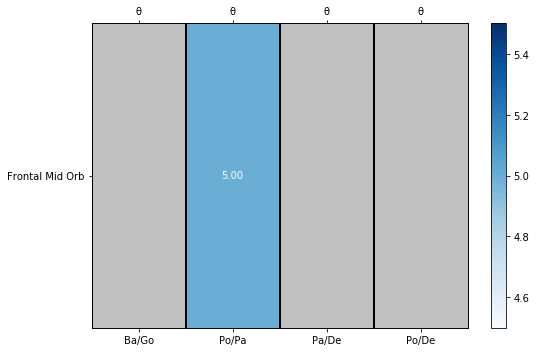

In [75]:
import matplotlib.pyplot as plt
from confusion_matrix import plot_confusion_matrix
%load_ext autoreload
%autoreload 2

freqnames = ['θ']#['VLFC','δ','θ','α']
codes = ['roi',plt.cm.Blues,1]

groups = len(np.unique(x_cond))
nconds = len(np.unique(x_cond))
plot_confusion_matrix(big_matrix, xtickslabels1=freqnames*groups, xtickslabels2=x_cond, 
    ytickslabels=roi_all,cmap=codes[1], ylabel='Regions',size=(8,5),cbsides=codes[2])
plot_name = path2save+'Matrix_recap_'+codes[0]+'_by_'+groupby+'_'+str(nconds)+'conds_rois'+str(option)+'.png'
plt.savefig(plot_name, dpi=300, bbox_inches='tight')
plt.show()

### FEATURE MATRIX
    Power, DA, Time

In [76]:
#Create the boolean matrix to show only regions sig in at least 60% of patients
da_mat, pow_mat, time_mat = np.array([]),np.array([]),np.array([])
x_freq, x_cond = [], []
feats = ['da','time','phase_change']
groupby = 'cond'

for cond,freq in product(sorted(conds),freqs[:]): #trick to impose iteration order for conds & freqs
    x_cond.append(conds[cond][0][:2].capitalize()+'/'+conds[cond][1][:2].capitalize())
    if cond == '0':
        filename60 = path_df+cond+'_Classif_'+conds[cond][1]+'_'+conds[cond][0]+'_'+freq+'_win1_patients'+str(option)+'.csv'
    else:
        filename60 = path_df+cond+'_Classif_'+conds[cond][0]+'_'+conds[cond][1]+'_'+freq+'_win1_patients'+str(option)+'.csv'
    if isfile(filename60):
        sig60, data = pd.read_csv(filename60), np.array([])
        #sig['phase_rad'] = (sig60['p0']-sig60['p1'])/sig60['p1']
        sig60['phase_change'] = (np.rad2deg(sig60['p1'])-np.rad2deg(sig60['p0']))
        #print(sig['phase_rad'],sig60['phase_change'])
        gr = sig60.groupby(['s_aal_RL','su_codes'])
        sel = gr[feats].agg(('max','min','mean'))
        da, time, rel_change = np.array([]), np.array([]), np.array([])
        for roi in roi_all:
            df_roi = sel[sel.index.get_level_values(0)==roi]
            da_val = df_roi.filter(like='da').filter(like='max').mean().values
            time_val = df_roi.filter(like='time').filter(like='mean').mean().values
            pow_min = df_roi.filter(like='phase_change').filter(like='min').mean().values
            pow_max = df_roi.filter(like='phase_change').filter(like='max').mean().values
            rel_change_val = []
            if abs(pow_min[0])>abs(pow_max[0]):
                rel_change_val = pow_min
            elif abs(pow_min[0])<abs(pow_max[0]):
                rel_change_val = pow_max
            elif abs(pow_min[0])==abs(pow_max[0]):
                rel_change_val = pow_max
            elif np.isnan(pow_min):
                rel_change_val = [np.nan]
            #print('value for',roi,pow_min, pow_max,rel_change_val, da_val, time_val)

            da = np.hstack((da,da_val)) if np.size(da) else da_val
            time = np.hstack((time,time_val)) if np.size(time) else time_val
            rel_change = np.hstack((rel_change,rel_change_val)) if np.size(rel_change) else rel_change_val
            #print('vector',len(da),len(time),len(rel_change))
        da_mat = np.vstack((da_mat,da)) if np.size(da_mat) else da
        time_mat = np.vstack((time_mat,time)) if np.size(time_mat) else time
        pow_mat = np.vstack((pow_mat,rel_change)) if np.size(pow_mat) else rel_change
    #print('vector',len(da_mat),len(time_mat),len(pow_mat))
da_mat,time_mat, pow_mat = da_mat.T, time_mat.T, pow_mat.T
_, idx = np.unique(x_cond,return_index=True) #to keep order
x_cond = [x_cond[i] for i in sorted(idx)]
print(da_mat.shape, time_mat.shape, pow_mat.shape, pow_mat)

(1,) (1,) (1,) [-54.14416946]


### Plot the confusion matrix

In [77]:
import matplotlib.pyplot as plt
from confusion_matrix import plot_confusion_matrix
%load_ext autoreload
%autoreload 2

freqnames = ['θ']#['VLFC','δ','θ','α']
codes = {0:['da',plt.cm.BuPu,1],
         1:['time',plt.cm.YlGn,1],
         2:['pow_change',plt.cm.seismic,2]}
feats_mat = [da_mat, time_mat, pow_mat]

# Plot non-normalized confusion matrix
for i,mat in enumerate(feats_mat):
    print(i, len(mat))
    groups = len(np.unique(x_cond))
    print(groups, x_cond)
    nconds = len(np.unique(x_cond))
    plot_confusion_matrix(mat, xtickslabels1=freqnames*groups, xtickslabels2=x_cond, 
        ytickslabels=roi_all,cmap=codes[i][1], ylabel='Regions',size=(8,5),cbsides=codes[i][2])
    plot_name = path2save+'Matrix_recap_'+codes[i][0]+'_by_'+groupby+'_'+str(nconds)+'conds_rois'+str(option)+'.png'
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 1
4 ['Ba/Go', 'Po/Pa', 'Pa/De', 'Po/De']
Confusion matrix, without normalization


/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/3_BrainpipeScripts/1_Intra_scripts/confusion_matrix.py:22: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax1.set_axis_bgcolor("silver")


IndexError: tuple index out of range